In [226]:
import sys

import numpy as  np
import matplotlib.pyplot as plt

from genimages import genimages

In [363]:
def FreeEnergy(X, mu, sigma_sq, pie, lamda, eps=1e-8):

    '''
    Free Energy wrt the variational distribution and the current estimate of 
    the parameters.

    Parameters
    ----------
    X: np.ndarray
        D x N data matrix
    mu: np.ndarray
        D x K matrix of means: mu @ S = X, where S is a K x N matrix of latents
    sigma_sq: float
        noise variance
    pie: np.ndarray
        K x 1 vector of priors on the latents
    lamda: np.ndarray
        K x N matrix of parameter values characterizing the variational
        distribution
    eps: float
        correction for numerical stability of log

    Returns
    -------
    F: int
        variational free energy wrt the factored distribution and the current 
        estimate of the parameters 
    '''

    N, D = X.shape[1], X.shape[0]
    lamda_sum_1 = np.sum(lamda, axis=1)
    ESS = lamda@lamda.T; np.fill_diagonal(ESS, lamda_sum_1)
    
    expectation_log_joint = -N*D/2 * (np.log(2*np.pi*sigma_sq)) + \
        -1/(2*sigma_sq) * (np.vdot(X, X) + np.vdot(ESS, mu.T@mu) - 2*np.vdot(lamda, mu.T@X)) + \
        np.dot(lamda_sum_1, np.log(pie+eps)) + np.dot(N-lamda_sum_1, np.log(1-pie+eps))
    H = - np.sum(lamda*np.log(lamda+eps) + (1-lamda)*np.log(1-lamda+eps))
    F = expectation_log_joint + H

    return F

In [169]:
def MeanField(X, mu, sigma_sq, pie, lamda, maxsteps, eps=1e-1):

    '''
    Factored Variational E-step for learning with Binary Latent Factor Model.

    Parameters
    ----------
    X: np.ndarray
        D x N data matrix
    mu: np.ndarray
        D x K matrix of means: mu @ S = X, where S is a K x N matrix of latents
    sigma_sq: float
        noise variance
    pie: np.ndarray
        K x 1 vector of priors on the latents
    lamda: np.ndarray
        K x N matrix of initial parameter values characterizing the variational
        distribution
    maxsteps: int
        maximum number of steps of the fixed point interations
    eps: float
        minimum improvement in free energy to continue iterations 

    Returns
    -------
    lamda: np.ndarray
        K x N matrix of updated parameter values characterizing the variational
        distribution
    F: float
        Variational Free Energy
    '''

    prior_odds = (1-pie) / (pie+1e-8)
    F = float('-inf')

    for _ in range(maxsteps):
        for i in range(pie.size):
            mu_i = mu[:, [i]]
            exponent = mu_i.T @ (-2*X + mu_i + 2*(mu@lamda-mu_i@lamda[[i]])) / (2*sigma_sq)
            lamda[[i]] = 1 / (1 + prior_odds[i]*np.exp(exponent))
        old_F, F = F, FreeEnergy(X, mu, sigma_sq, pie, lamda)
        if F-old_F < eps:
            break

    return lamda, F

In [170]:
def MStep(X, lamda):

    '''
    Maximisation step for learning with Binary Latent Factor Model.
    Parameters
    ----------
    X: np.ndarray
        D x N data matrix
    lamda: np.ndarray
        K x N matrix of parameter values characterizing the variational 
        distribution

    Returns
    -------
    mu: np.ndarray
        D x K matrix of means: mu @ S = X
    sigma_sq: float
        updated estimate of noise variance
    pie: np.ndarray
        K x 1 vector of parameters characterising the distribution on 
        the latents
    '''

    N, D, K = X.shape[1], X.shape[0], lamda.shape[0]
    ESS = lamda@lamda.T; np.fill_diagonal(ESS, np.sum(lamda, axis=1))

    mu = X @ lamda.T @ np.linalg.inv(ESS + 1e-8*np.eye(K))
    sigma_sq = (np.vdot(X, X) + np.vdot(ESS, mu.T@mu) - 2*np.vdot(lamda, mu.T@X)) / (N*D)
    pie = np.mean(lamda, axis=1)

    return mu, sigma_sq, pie

In [338]:
def LearnBinFactors(X, K, iterations):

    '''
    Factored Variational EM for learning with Binary Latent Factor Model.

    Parameters
    ----------
    X: np.ndarray
        D x N data matrix
    K: int
        number of latent binary factors
    iterations: int
        maximum number of iterations of EM

    Returns
    -------
    mu: np.ndarray
        D x K matrix of means: mu @ S = X
    sigma_sq: float
        estimate of noise variance
    pie: np.ndarray
        K x 1 vector of parameters characterising the distribution on the
        latents
    Fs: np.ndarray
        Free energy values after each iteration
    '''

    D, N = X.shape
    mu = np.random.randn(D, K); sigma_sq = np.random.rand(); pie = np.random.rand(K)
    lamda = np.random.rand(K, N)

    Fs = np.zeros(iterations); Fs[0] = FreeEnergy(X, mu, sigma_sq, pie, lamda)
    for i in range(iterations):
        lamda, _ = MeanField(X, mu, sigma_sq, pie, lamda, maxsteps=50, eps=1e-2)
        mu, sigma_sq, pie = MStep(X, lamda)
        Fs[i] = FreeEnergy(X, mu, sigma_sq, pie, lamda)
        if i != 0:
            fe_increment = Fs[i] - Fs[i-1]
            assert fe_increment >= 0., fe_increment
            if fe_increment < 1e-2:
                break
            
    return mu, sigma_sq, pie, Fs[:i+1]

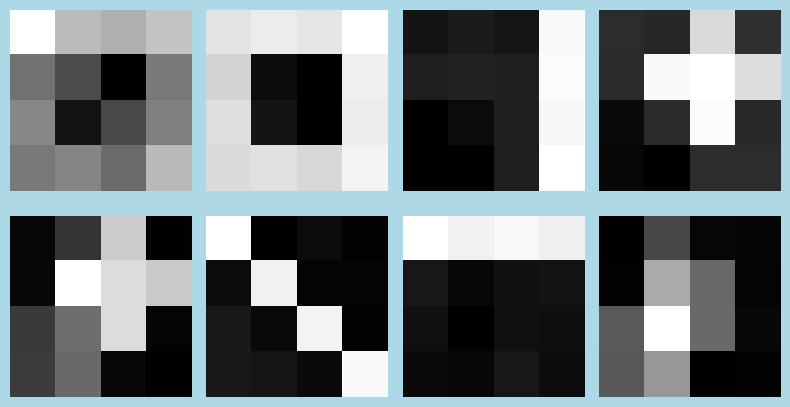

In [339]:
N = 400
X = genimages(N).T
D = X.shape[0]

K = 8
mu, sigma_sq, pie, Fs = LearnBinFactors(X, K, 100)

# plt.plot(Fs, color='blue')
# plt.xlabel('EM Iterations', font='serif', size=12)
# plt.ylabel('Free Eenrgy', font='serif', size=12)
# plt.title('Factored Variational EM', font='serif', size=14)
# plt.tight_layout()
# plt.grid()
# plt.show()

fig = plt.figure(figsize=(8, 4.5))
fig.patch.set_facecolor('lightblue')
for k in range(K):
    plt.subplot(2, 4, k+1)
    plt.imshow(np.reshape(mu[:,k], (4, 4)), cmap=plt.gray(), interpolation='none')
    plt.axis('off')
plt.tight_layout()
plt.show()

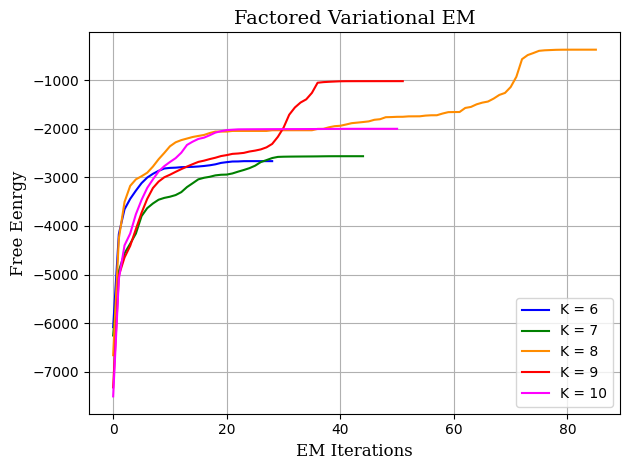

In [314]:
N = 400
X = genimages(N).T
D = X.shape[0]

for k, color in zip(range(6, 11), ('blue', 'green', 'darkorange', 'red', 'magenta')):
    mu, sigma_sq, pie, Fs = LearnBinFactors(X, k, 100)
    plt.plot(Fs, color=color, label=f'K = {k}')

plt.xlabel('EM Iterations', font='serif', size=12)
plt.ylabel('Free Eenrgy', font='serif', size=12)
plt.title('Factored Variational EM', font='serif', size=14)
plt.tight_layout()
plt.grid()
plt.legend()
plt.show()

In [366]:
def MeanFieldToConvergence(X, mu, sigma_sq, pie, lamda):

    prior_odds = (1-pie) / (pie+1e-8)
    Fs = [FreeEnergy(X, mu, sigma_sq, pie, lamda)]

    lamda_changed, F_changed = True, True

    while lamda_changed or F_changed:
        lamda_old = lamda.copy()
        for i in range(pie.size):
            mu_i = mu[:, [i]]
            exponent = mu_i.T @ (-2*X + mu_i + 2*(mu@lamda-mu_i@lamda[[i]])) / (2*sigma_sq)
            lamda[[i]] = 1 / (1 + prior_odds[i]*np.exp(exponent))
        F = FreeEnergy(X, mu, sigma_sq, pie, lamda)
        lamda_changed = not np.allclose(lamda, lamda_old)
        F_changed = not F == Fs[-1]; Fs.append(F)
        
    return lamda, np.array(Fs)

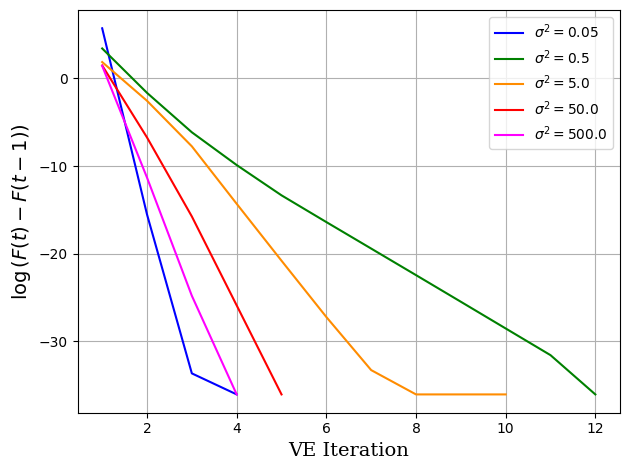

In [342]:
lamda = np.random.rand(K, 1)
for s_sq, color in zip((5e-2, 5e-1, 5e0, 5e1, 5e2), ('blue', 'green', 'darkorange', 'red', 'magenta')):
    _, Fs = MeanFieldToConvergence(X[:, [0]], mu, s_sq, pie, lamda.copy())
    plt.plot(range(1, Fs.size), np.log(np.clip(Fs[1:]-Fs[:-1], a_min=sys.float_info.epsilon, a_max=None)), color=color, label=rf'$\sigma^2 = {s_sq}$')
plt.xlabel('VE Iteration', font='serif', size=14)
plt.ylabel(r'$\log\left(F(t)-F(t-1)\right)$', font='serif', size=14)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

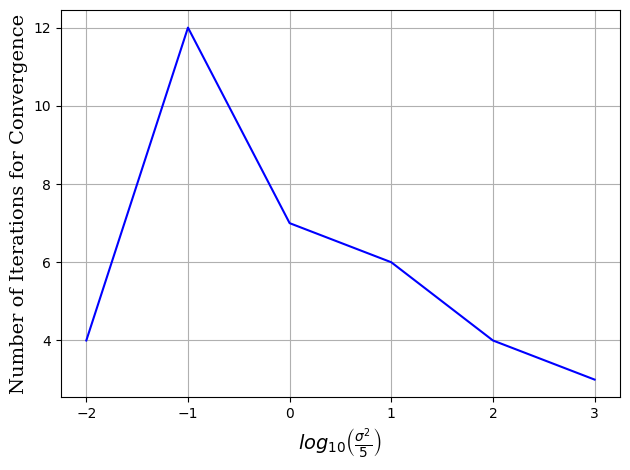

In [349]:
lamda = np.random.rand(K, 1)
s_sqs = 5 * np.power(10., np.arange(-2, 4))

n_iters_for_conv = np.zeros((len(s_sqs), 100))

for i, s_sq in enumerate(s_sqs):
    for j in range(n_iters_for_conv.shape[1]):
        _, Fs = MeanFieldToConvergence(X[:, [0]], mu, s_sq, pie, lamda.copy())
        n_iters_for_conv[i, j] = Fs.size-1

plt.plot(np.log10(s_sqs/5), np.mean(n_iters_for_conv, axis=1), color='blue')
plt.xlabel(r'$log_{10}\left(\frac{\sigma^2}{5}\right)$', font='serif', size=14)
plt.ylabel('Number of Iterations for Convergence', font='serif', size=14)
plt.grid()
plt.tight_layout()
plt.show()

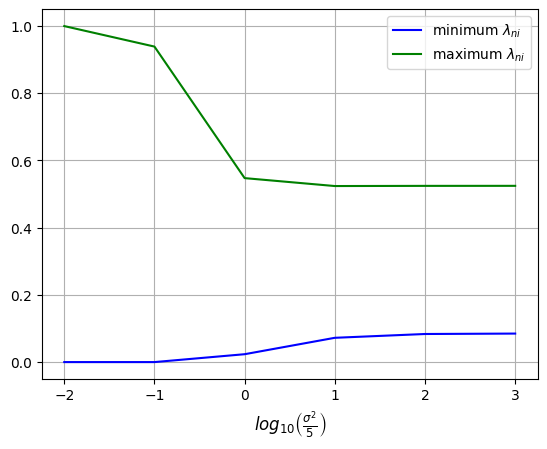

In [311]:
lamda = np.random.rand(K, 1)
s_sqs = 5 * np.power(10., np.arange(-2, 4))

mins = np.zeros((len(s_sqs), 100))
maxs = np.zeros((len(s_sqs), 100))

for i, s_sq in enumerate(s_sqs):
    for j in range(n_iters_for_conv.shape[1]):
        lamda, _ = MeanFieldToConvergence(X[:, [0]], mu, s_sq, pie, lamda.copy())
        mins[i, j] = np.min(lamda); maxs[i, j] = np.max(lamda)

plt.plot(np.log10(s_sqs/5), np.mean(mins, axis=1), label=r'minimum $\lambda_{ni}$', color='blue')
plt.plot(np.log10(s_sqs/5), np.mean(maxs, axis=1), label=r'maximum $\lambda_{ni}$', color='green')
plt.xlabel(r'$log_{10}\left(\frac{\sigma^2}{5}\right)$', font='serif', size=12)
plt.grid()
plt.legend()
plt.show()

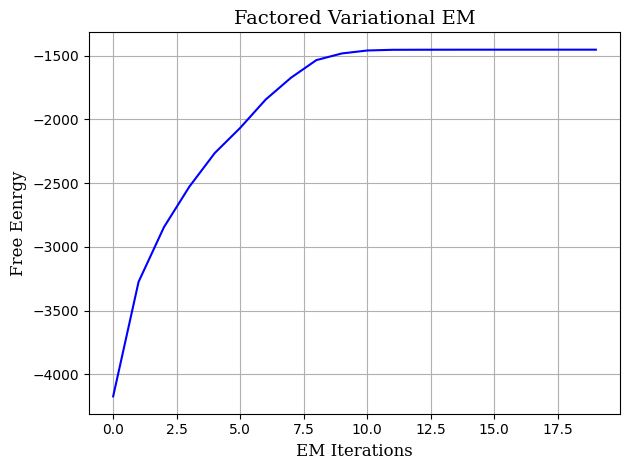

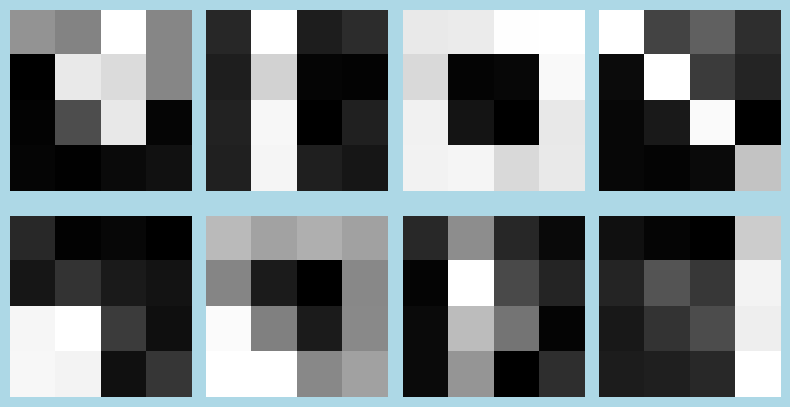

In [350]:
from genimages import m1, m2, m3, m4, m5, m6, m7, m8

def LearnBinFactorsWithPrior(X, K, iterations):

    D, N = X.shape
    mu = np.clip(np.vstack((m1, m2, m3, m4, m5, m6, m7, m8)).T + 0.8*np.random.rand(D, K), a_min=0., a_max=1.)
    sigma_sq = np.random.rand(); pie = np.random.rand(K)
    lamda = np.random.rand(K, N)

    Fs = np.zeros(iterations); Fs[0] = FreeEnergy(X, mu, sigma_sq, pie, lamda)
    for i in range(iterations):
        lamda, _ = MeanField(X, mu, sigma_sq, pie, lamda, maxsteps=50, eps=1e-2)
        mu, sigma_sq, pie = MStep(X, lamda)
        Fs[i] = FreeEnergy(X, mu, sigma_sq, pie, lamda)
        if i != 0:
            fe_increment = Fs[i] - Fs[i-1]
            assert fe_increment >= 0., fe_increment
            if fe_increment < 1e-2:
                break
            
    return mu, sigma_sq, pie, Fs[:i+1]

X = genimages(400).T
K = 8
mu, sigma_sq, pie, Fs = LearnBinFactorsWithPrior(X, K, 100)

plt.plot(Fs, color='blue')
plt.xlabel('EM Iterations', font='serif', size=12)
plt.ylabel('Free Eenrgy', font='serif', size=12)
plt.title('Factored Variational EM', font='serif', size=14)
plt.tight_layout()
plt.grid()
plt.show()

fig = plt.figure(figsize=(8, 4.5))
fig.patch.set_facecolor('lightblue')
for k in range(K):
    plt.subplot(2, 4, k+1)
    plt.imshow(np.reshape(mu[:,k], (4, 4)), cmap=plt.gray(), interpolation='none')
    plt.axis('off')
plt.tight_layout()
plt.show()

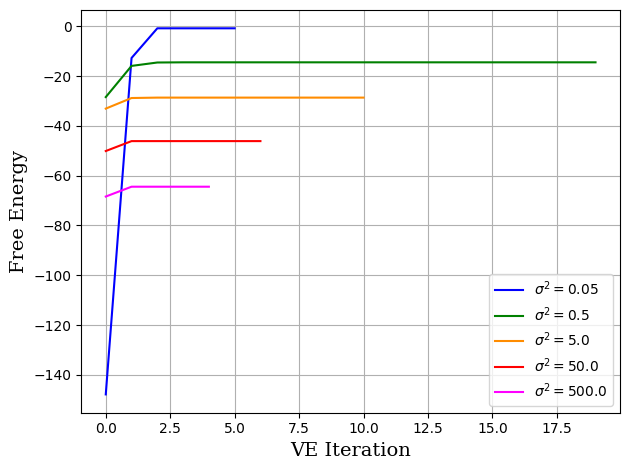

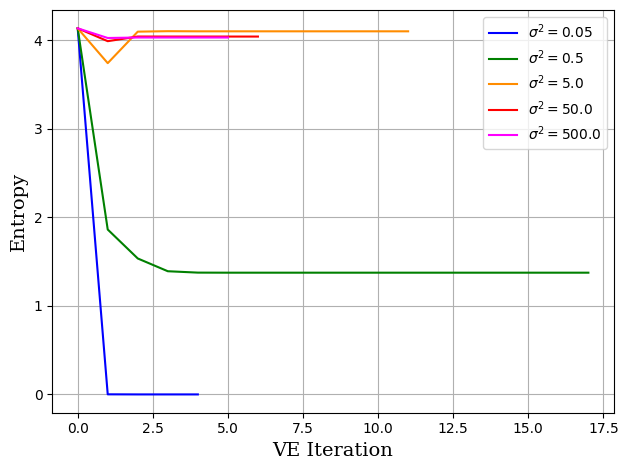

In [370]:
def FreeEnergyWithEntropy(X, mu, sigma_sq, pie, lamda, eps=1e-8):

    N, D = X.shape[1], X.shape[0]
    lamda_sum_1 = np.sum(lamda, axis=1)
    ESS = lamda@lamda.T; np.fill_diagonal(ESS, lamda_sum_1)
    
    expectation_log_joint = -N*D/2 * (np.log(2*np.pi*sigma_sq)) + \
        -1/(2*sigma_sq) * (np.vdot(X, X) + np.vdot(ESS, mu.T@mu) - 2*np.vdot(lamda, mu.T@X)) + \
        np.dot(lamda_sum_1, np.log(pie+eps)) + np.dot(N-lamda_sum_1, np.log(1-pie+eps))
    H = - np.sum(lamda*np.log(lamda+eps) + (1-lamda)*np.log(1-lamda+eps))
    F = expectation_log_joint + H

    return H, F

def MeanFieldWithEntropy(X, mu, sigma_sq, pie, lamda):

    prior_odds = (1-pie) / (pie+1e-8)
    Fs = [None]; Hs = [None]; Hs[0], Fs[0] = FreeEnergyWithEntropy(X, mu, sigma_sq, pie, lamda)

    lamda_changed, F_changed = True, True

    while lamda_changed or F_changed:
        lamda_old = lamda.copy()
        for i in range(pie.size):
            mu_i = mu[:, [i]]
            exponent = mu_i.T @ (-2*X + mu_i + 2*(mu@lamda-mu_i@lamda[[i]])) / (2*sigma_sq)
            lamda[[i]] = 1 / (1 + prior_odds[i]*np.exp(exponent))
        H, F = FreeEnergyWithEntropy(X, mu, sigma_sq, pie, lamda)
        lamda_changed = not np.allclose(lamda, lamda_old)
        F_changed = not F == Fs[-1]; Fs.append(F); Hs.append(H)
        
    return lamda, np.array(Fs), np.array(Hs)

lamda = np.random.rand(K, 1)
for s_sq, color in zip((5e-2, 5e-1, 5e0, 5e1, 5e2), ('blue', 'green', 'darkorange', 'red', 'magenta')):
    _, Fs, Hs = MeanFieldWithEntropy(X[:, [0]], mu, s_sq, pie, lamda.copy())
    plt.plot(Fs, color=color, label=rf'$\sigma^2 = {s_sq}$')
plt.xlabel('VE Iteration', font='serif', size=14)
plt.ylabel('Free Energy', font='serif', size=14)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

lamda = np.random.rand(K, 1)
for s_sq, color in zip((5e-2, 5e-1, 5e0, 5e1, 5e2), ('blue', 'green', 'darkorange', 'red', 'magenta')):
    _, Fs, Hs = MeanFieldWithEntropy(X[:, [0]], mu, s_sq, pie, lamda.copy())
    plt.plot(Hs, color=color, label=rf'$\sigma^2 = {s_sq}$')
plt.xlabel('VE Iteration', font='serif', size=14)
plt.ylabel('Entropy', font='serif', size=14)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()